In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

insurance = pd.read_csv('insurance.csv')

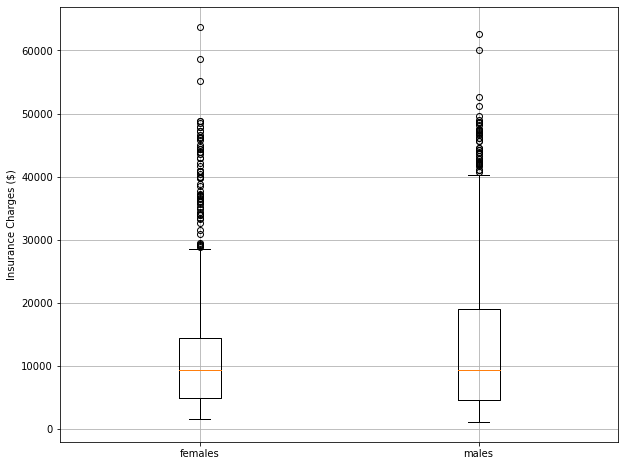

In [38]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
females = insurance[insurance['sex'] == 'female']
males = insurance[insurance['sex'] == 'male']

## Creating side-by-side box plots
plt.boxplot([females['charges'], males['charges']], labels = ['females', 'males'])
plt.ylabel('Insurance Charges ($)')
plt.grid()


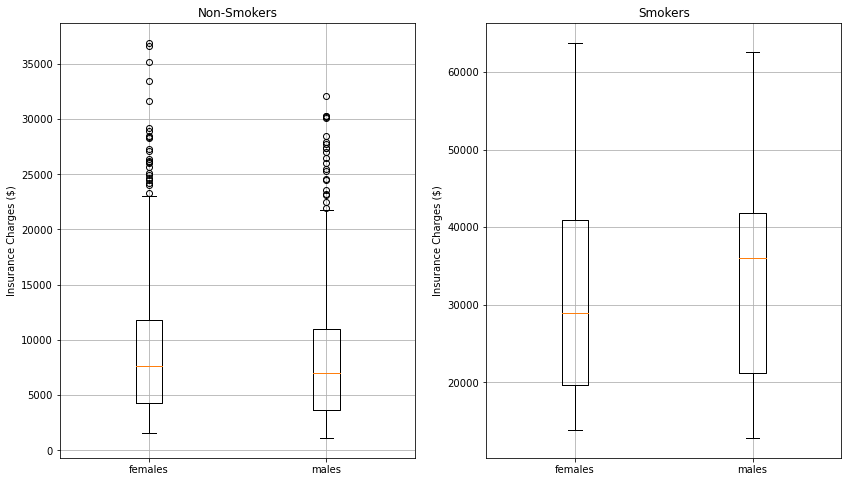

In [39]:
## Creating a new figure
fig, axes = plt.subplots(1, 2, figsize = (14, 8))

## Subsetting the data
nonsmokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'no')]
nonsmokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'no')]

smokers_females = insurance[(insurance['sex'] == 'female') & (insurance['smoker'] == 'yes')]
smokers_males = insurance[(insurance['sex'] == 'male') & (insurance['smoker'] == 'yes')]

axes[0].boxplot([nonsmokers_females['charges'], nonsmokers_males['charges']], labels = ['females', 'males'])
axes[0].set_ylabel('Insurance Charges ($)')
axes[0].set_title('Non-Smokers')
axes[0].grid()

## Plotting the second histogram
axes[1].boxplot([smokers_females['charges'], smokers_males['charges']], labels = ['females', 'males'])
axes[1].set_ylabel('Insurance Charges ($)')
axes[1].set_title('Smokers')
axes[1].grid()

In [42]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,northeast,northwest,southeast
0,19,1,27.900,0,1,southwest,16884.92400,0,0,0,0,0,0
1,18,1,33.770,1,1,southeast,1725.55230,0,0,1,0,0,1
2,28,1,33.000,3,1,southeast,4449.46200,0,0,1,0,0,1
3,33,1,22.705,0,1,northwest,21984.47061,0,1,0,0,1,0
4,32,1,28.880,0,1,northwest,3866.85520,0,1,0,0,1,0


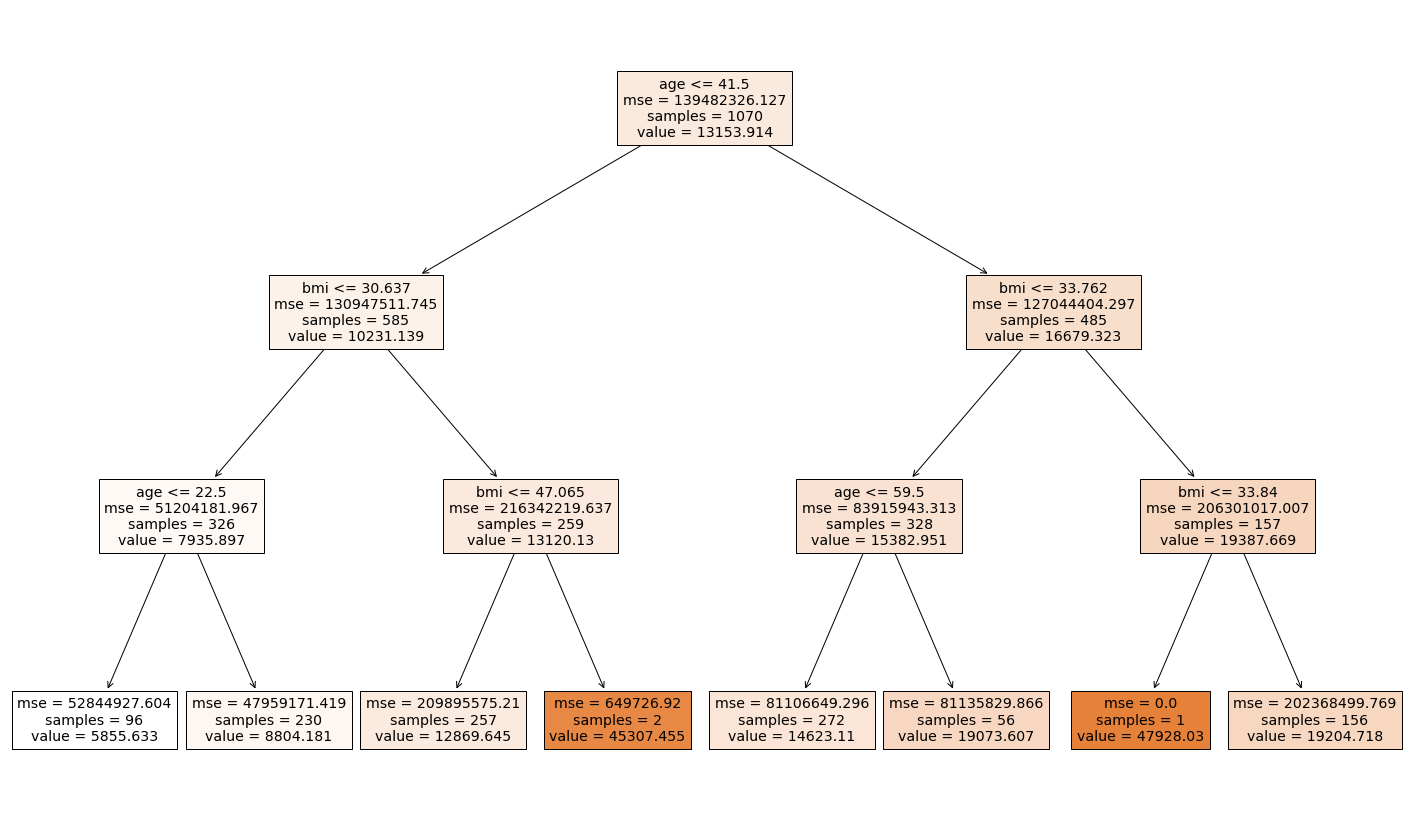

In [43]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True);

## saving the plot
# plt.savefig('chapter4_plot3.pdf')


In [44]:
## Forcing to be data-frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Engineering features from decision-tree
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] <= 32.5), 1, 0)
X_train['interaction_2'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 32.5) & (X_train['age'] <= 44.5), 1, 0)
X_train['interaction_3'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 44.5) & (X_train['age'] < 51.5), 1, 0)
X_train['interaction_4'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 51.5), 1, 0)

X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] <= 32.5), 1, 0)
X_test['interaction_2'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 32.5) & (X_test['age'] <= 44.5), 1, 0)
X_test['interaction_3'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 44.5) & (X_test['age'] < 51.5), 1, 0)
X_test['interaction_4'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 51.5), 1, 0)

In [45]:
insurance['interaction_4'] = np.where((insurance['smoker'] == 0) & (insurance['age'] > 51.5), 1, 0)

# Defining input and target variable
X = insurance[['age', 'bmi', 'children', 'smoker', 'interaction_4']]
Y = insurance['charges']

# Splitting the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.2)

# Scaling the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [46]:
X_train

array([[0.63043478, 0.35756574, 0.6       , 0.        , 0.        ],
       [0.73913043, 0.20143192, 0.2       , 0.        , 0.        ],
       [0.91304348, 0.3327826 , 0.        , 0.        , 0.        ],
       ...,
       [0.15217391, 0.37931984, 0.        , 0.        , 0.        ],
       [0.06521739, 0.55197577, 0.        , 0.        , 0.        ],
       [0.80434783, 0.33484786, 0.        , 0.        , 0.        ]])

In [50]:
X_train_4 = pd.DataFrame(X_train).iloc[:, 0:3]
X_train_4

,0,1,2
0,0.630435,0.357566,0.6
1,0.739130,0.201432,0.2
2,0.913043,0.332783,0.0
3,0.217391,0.197301,0.6
4,0.543478,0.175823,0.0
...,...,...,...
1065,0.260870,0.606223,0.2
1066,0.760870,0.159576,0.6
1067,0.152174,0.379320,0.0
1068,0.065217,0.551976,0.0


In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
## Defining the hyper-parameters for RF
RF_param_grid = {'n_estimators': [100, 300, 500],
                 'min_samples_split': [10, 15], 
                 'min_samples_leaf': [5, 7], 
                 'max_depth' : [3, 5, 7]}

# Performing GridSearch
RF_grid_search = GridSearchCV(RandomForestRegressor(), RF_param_grid, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1).fit(X_train, Y_train)

# Extracting the best model
RF_model = RF_grid_search.best_estimator_

# Predicting on validation and test
RF_val_pred = RF_model.predict(X_val)
RF_test_pred = RF_model.predict(X_test)

# Computing the mse on validation and test
RF_val_mse = mean_squared_error(Y_val, RF_val_pred)
RF_test_mse = mean_squared_error(Y_test, RF_test_pred)
print("The mse of the model Random Forest Regressior on the validation dataset is: ", round(RF_val_mse), 1)
print("The mse of the model Random Forest Regressior on the test dataset is: ", round(RF_test_mse), 1)


The mse of the model Random Forest Regressior on the validation dataset is:  26911794 1
The mse of the model Random Forest Regressior on the test dataset is:  34774320 1


In [34]:
## Defining the hyper-parameters for svm
svm_param_grid = {'kernel': ['rbf', 'poly', 'sigmoid'], 
                  'C': [0.01, 0.1, 1, 10],
                  'gamma': [0.001, 0.01, 0.1, 1]}


svm_grid_search = GridSearchCV(SVR(), svm_param_grid, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1).fit(X_train, Y_train)

# Extracting the best model
svm_md = svm_grid_search.best_estimator_

# Predicting on validation and test
svm_val_pred = svm_md.predict(X_val)
svm_test_pred = svm_md.predict(X_test)

# Computing the mse on validation and test
svm_val_mse = mean_squared_error(Y_val, svm_val_pred)
svm_test_mse = mean_squared_error(Y_test, svm_test_pred)
print("The mse of the model Support Vector Machine Regressior on the validation dataset is: ", round(svm_val_mse, 1))
print("The mse of the model Support Vector Machine Regressior on the test dataset is: ", round(svm_test_mse, 1))


The mse of the model Support Vector Machine Regressior on the validation dataset is:  123381548.6
The mse of the model Support Vector Machine Regressior on the test dataset is:  94198430.1


In [36]:
## Ensemble
X_ensemble = pd.concat([pd.DataFrame(RF_val_pred), pd.DataFrame(svm_val_pred)], axis = 1)

## Performing grid search
RF_grid_search = GridSearchCV(RandomForestRegressor(), RF_param_grid, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1).fit(X_ensemble, Y_val)

# Extracting the best model
RF_model_ensemble = RF_grid_search.best_estimator_

# Predicting on test
RF_ensemble_pred = RF_model_ensemble.predict(pd.concat([pd.DataFrame(RF_test_pred), pd.DataFrame(svm_test_pred)], axis = 1))


# Computing the mse on validation and test
RF_ensemble_mse = mean_squared_error(Y_test, RF_ensemble_pred)
print("The mse of the model Random Forest Regressior on the test dataset is: ", round(RF_ensemble_mse, 1))


The mse of the model Random Forest Regressior on the test dataset is:  38451822.3


### Based on my results, Random Forest had the best mean squared error.